In [9]:
'''やること

1.データセットの確認
2.前処理
3.モデル作成
4.評価
5.可視化

sklearnのirisデータセットを使い、基本はsklearnのチュートリアルに沿ってkNN。
こちら（https://qiita.com/SE96UoC5AfUt7uY/items/84c1b4acebb018d09b9c）に紹介しているものが私のやるイメージに近い...。
k,distanceのクロスバリデーションをもう少し掘り下げるか。
クロスバリデーションでやっちゃうと可視化できないなあ
'''

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[[ 5.1  3.5  1.4  0.2]]


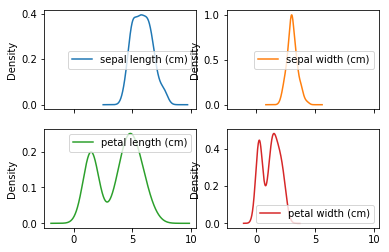

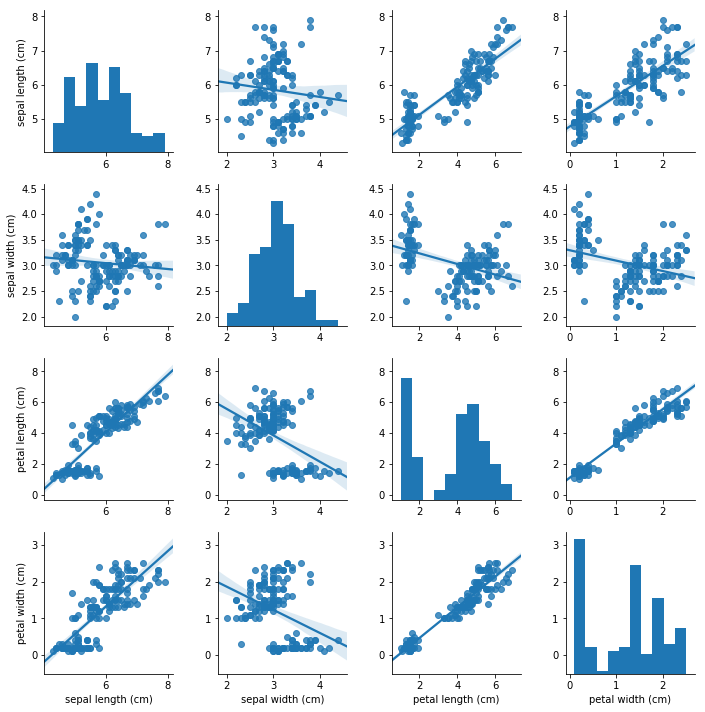

In [150]:
'''1.データセットの確認
'''

# 1-1.データセットの取得
from sklearn.datasets import load_iris
iris = load_iris()


# 1-2.データの外観を確認
print(iris.data.shape) # (150, 4)　150個のサンプルが４つの特徴量を保持
print(iris.feature_names) # 特徴量の名前['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
print(iris.target_names) # 品種名['setosa' 'versicolor' 'virginica']
print(iris.data[:1])# どんな感じか確認


# 1-3.各変数ごとの分布を確認
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df.plot(kind="kde",subplots=True,layout=(2,2)) # 各特徴量ごとにグラフを分割して表示
plt.show()


# 1-4.４つある変数のうち２つを選んで相関を確認
df['target'] = iris.target # 標準化した後にラベルを付与
sns.pairplot(data=df, vars=iris.feature_names,kind='reg')


In [78]:
'''2.前処理
特徴量ごとに絶対値の大きさが異なります。単純に距離を求めるとなると、この絶対値の大きさの違いのせいで、うまくいかない可能性があります。
なので、あらかじめ各特徴量の値を「正規化」しておきます。
今回は一般的な正規化手法を使っています。
'''

# 2-1.標準化
from sklearn.preprocessing import StandardScaler 

sc = StandardScaler()
x_std = sc.fit_transform(iris.data)
print(x_std[:3])


# 2-2.次元削減(「lsa」を使って次元削減を行います)
from sklearn.decomposition import TruncatedSVD

# 2-2-1.パラメータの調整
list_n_comp = [1,2,3]
for i in list_n_comp:
    lsa = TruncatedSVD(n_components=i,random_state = 0)
    lsa.fit_transform(x_std) 
    print('次元削減後の特徴量が{0}の時の説明できる分散の割合合計は{1}です'.format(i,round((sum(lsa.explained_variance_ratio_)),2)))

'''
特徴量が４しかないので次元削減は不要な気もしますが、分析結果を二次元で可視化したいので、特徴量を２次元に削減します。
'''
# 2-2-2.次元削減(説明変数を２次元にしました)
lsa = TruncatedSVD(n_components=2,random_state = 0)
x_std = lsa.fit_transform(x_std) 


[[-0.90068117  1.03205722 -1.3412724  -1.31297673]
 [-1.14301691 -0.1249576  -1.3412724  -1.31297673]
 [-1.38535265  0.33784833 -1.39813811 -1.31297673]]
次元削減後の特徴量が1の時の説明できる分散の割合合計は0.73です
次元削減後の特徴量が2の時の説明できる分散の割合合計は0.96です
次元削減後の特徴量が3の時の説明できる分散の割合合計は0.99です
(150, 2)


In [88]:
'''3.モデル作成
パラメータ調整
今回調整するパラメータは「重み付けの基準」、「近くの何個のデータを参考にするか」、の２つである。
「重み付けの基準」については「weigths」で、「近くの何個のデータを参考にするか」については「n_neighbors」で指定している。
'''

# 3-1.調整するパラメータの指定
tuned_parameters ={ 'weights': ['uniform','distance'], 'n_neighbors': [3,5,10,20,30,50] }

# 3-2.分類器作成（パラメータ調整用）
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring="accuracy",cv=5, n_jobs=-1)# 上記で用意したパラメーターごとに交差検証を実施
clf.fit(x_std, iris.target ) # 学習
for params, mean_score, all_scores in clf.grid_scores_:
        print ("{0},精度:{1} ,標準誤差=(+/- {2}) ".format(params, round((mean_score),3), round((all_scores.std() / 2),3))) # 各パラメータごとの精度を確認
        
# 3-3.モデル作成
clf  = KNeighborsClassifier(n_neighbors = 20, weights ='uniform') #n_neighbors = 20, weights ='uniform' がよさそうです。


{'n_neighbors': 3, 'weights': 'uniform'},精度:0.9 ,標準誤差=(+/- 0.028) 
{'n_neighbors': 3, 'weights': 'distance'},精度:0.893 ,標準誤差=(+/- 0.029) 
{'n_neighbors': 5, 'weights': 'uniform'},精度:0.913 ,標準誤差=(+/- 0.023) 
{'n_neighbors': 5, 'weights': 'distance'},精度:0.907 ,標準誤差=(+/- 0.027) 
{'n_neighbors': 10, 'weights': 'uniform'},精度:0.913 ,標準誤差=(+/- 0.023) 
{'n_neighbors': 10, 'weights': 'distance'},精度:0.907 ,標準誤差=(+/- 0.022) 
{'n_neighbors': 20, 'weights': 'uniform'},精度:0.92 ,標準誤差=(+/- 0.017) 
{'n_neighbors': 20, 'weights': 'distance'},精度:0.92 ,標準誤差=(+/- 0.025) 
{'n_neighbors': 30, 'weights': 'uniform'},精度:0.9 ,標準誤差=(+/- 0.015) 
{'n_neighbors': 30, 'weights': 'distance'},精度:0.907 ,標準誤差=(+/- 0.024) 
{'n_neighbors': 50, 'weights': 'uniform'},精度:0.853 ,標準誤差=(+/- 0.023) 
{'n_neighbors': 50, 'weights': 'distance'},精度:0.907 ,標準誤差=(+/- 0.024) 


In [116]:
'''4.評価
https://pythondatascience.plavox.info/scikit-learn/%E5%88%86%E9%A1%9E%E7%B5%90%E6%9E%9C%E3%81%AE%E3%83%A2%E3%83%87%E3%83%AB%E8%A9%95%E4%BE%A1
'''


# 4-1.混同行列
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(x_std)
print('--混同行列--')
print(confusion_matrix(y_pred, iris.target))


# 4-2.色々
from sklearn.metrics import classification_report
print('--精度、検出率、F値、支持度--')
print(classification_report(iris.target, y_pred, target_names=['setosa' ,'versicolor', 'virginica']))



--混同行列--
[[50  0  0]
 [ 0 44  6]
 [ 0  6 44]]
--精度、検出率、F値、支持度--
             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        50
 versicolor       0.88      0.88      0.88        50
  virginica       0.88      0.88      0.88        50

avg / total       0.92      0.92      0.92       150



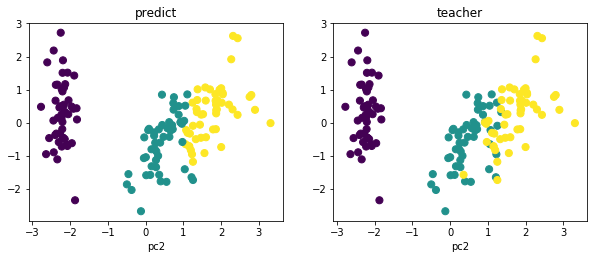

'\nkNNだと近くのデータに基づいてクラス分類してしまうことがよくわかりますね\n'

In [152]:
'''5.可視化
せっかくだし、ちょっと可視化したい
'''
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))

# 予測
plt.subplot(2,2,1)
plt.scatter(x_std[:,0], x_std[:,1],c = y_pred, s=50)
plt.xlabel('pc1')
plt.xlabel('pc2')
plt.title('predict')

# 正解
# plt.figure(figsize=(3, 2))
plt.subplot(2,2,2)
plt.scatter(x_std[:,0], x_std[:,1],c = iris.target, s=50)
plt.xlabel('pc1')
plt.xlabel('pc2')
plt.title('teacher')


plt.show()


'''
kNNだと近くのデータに基づいてクラス分類してしまうことがよくわかりますね
'''